1. Intrall and import necessary library

In [ ]:
!pip install pyrealsense2 # Install the pyrealsense2 module
!pip install open3d # Install the open3d library

import torch
import cv2
import numpy as np
import pyrealsense2 as rs
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from sklearn.decomposition import PCA

import open3d as o3d

ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^
ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


ModuleNotFoundError: No module named 'torch'

# install necessary packages


In [3]:
   !apt-get install -y xvfb
   !pip install pyvirtualdisplay


'apt-get' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
   from pyvirtualdisplay import Display
   display = Display(visible=0, size=(1024, 768))
   display.start()


FileNotFoundError: [WinError 2] The system cannot find the file specified

In [2]:
!pip install open3d # Install the open3d library
import open3d as o3d

ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2. Download RGBD video from Gooele drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


3. Load YOLOv5 Model.

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

4. Create pipeline for videos

In [ ]:
# 设置 .bag 文件路径
bag_file_path = "/content/drive/MyDrive/CV_Project/RGBD_Video/20241114_154335.bag"

# 初始化 RealSense 管道
pipeline = rs.pipeline()
config = rs.config()

# Enable the bag file as the source for the pipeline.
rs.config.enable_device_from_file(config, bag_file_path)

# Select a valid resolution, format and frame rate based on the bag file's content.
profile = pipeline.start(config)

# Get the active streams
streams = profile.get_streams()
for stream in streams:
    print(f"Stream: {stream.stream_type()}, Format: {stream.format()}, Resolution: {stream.as_video_stream_profile().width()}x{stream.as_video_stream_profile().height()}, FPS: {stream.as_video_stream_profile().fps()}")

config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
pc = rs.pointcloud()

Stream: stream.depth, Format: format.z16, Resolution: 640x480, FPS: 15
Stream: stream.color, Format: format.rgb8, Resolution: 640x480, FPS: 15


4. Set the intrinsic parameter of the camera (D435i)

In [ ]:
# 获取深度比例
depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()
print("Depth Scale (meters per unit):", depth_scale)

intrinsics = None

Depth Scale (meters per unit): 0.0010000000474974513


5. Obeject Dectection and point cloud generation

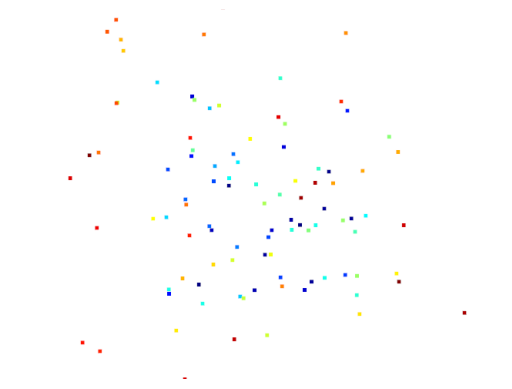

In [5]:
#test open3d
import open3d as o3d
import numpy as np
from matplotlib import pyplot as plt

# 创建 Visualizer 窗口
vis = o3d.visualization.Visualizer()
vis.create_window(width=640, height=480)
geometry_added = False

# 创建点云
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.random.rand(100, 3))

if not geometry_added:
    vis.add_geometry(pcd)
    geometry_added = True

# 渲染一帧
vis.poll_events()
vis.update_renderer()

# 保存截图
vis.capture_screen_image("output.png")
vis.destroy_window()

# 在 Colab 显示截图
img = plt.imread("output.png")
plt.imshow(img)
plt.axis("off")
plt.show()


In [ ]:
# Open3D 可视化窗口设置
vis = o3d.visualization.Visualizer()
vis.create_window(width=640, height=480)
geometry_added = False

# 视频保存设置
output_video = "pointcloud_video.avi"
fps = 15
video_writer = cv2.VideoWriter(output_video, cv2.VideoWriter_fourcc(*'XVID'), fps, (640, 480))

NameError: name 'cv2' is not defined

: 

In [ ]:
# Helper function for estimating the pose using PCA
def estimate_pose(point_cloud):
    pca = PCA(n_components=3)
    pca.fit(point_cloud)
    center = point_cloud.mean(axis=0)
    directions = pca.components_
    variances = pca.explained_variance_
    return center, directions, variances

In [ ]:
# helper function for updating visualization
def render_frame(points, center, directions, variances):
    # 更新点云
    pcd.points = o3d.utility.Vector3dVector(points)
    vis.update_geometry(pcd)

    # 更新坐标轴
    axes.translate(-axes.get_center(), relative=True)
    axes.translate(center, relative=True)

    vis.poll_events()
    vis.update_renderer()

    # 截取Open3D窗口的图像
    img = np.asarray(vis.capture_screen_float_buffer(do_render=True))
    img = (img * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

Main Loop for generating video with point cloud

In [ ]:
try:
    while True:
        # 从 RealSense 读取帧
        frames = pipeline.wait_for_frames()
        color_frame = frames.get_color_frame()
        depth_frame = frames.get_depth_frame()

        if not color_frame or not depth_frame:
            continue

        # 绑定颜色并计算点云
        pc.map_to(color_frame)
        points = pc.calculate(depth_frame)

        # 获取点云数据
        verts = np.asanyarray(points.get_vertices()).view(np.float32).reshape(-1, 3)
        colors = np.asanyarray(points.get_texture_coordinates()).reshape(-1, 2)

        color_image = np.asanyarray(color_frame.get_data())
        depth_image = np.asanyarray(depth_frame.get_data())

        if intrinsics is None:
            intrinsics = depth_frame.profile.as_video_stream_profile().intrinsics

        # 使用 YOLO 进行物体检测
        results = model(color_image)
        results_df = results.pandas().xyxy[0]

        # Crop the bounding box from the frame
        for _, row in results_df.iterrows():
            if row['name'] == 'cup':
                x_min, y_min, x_max, y_max = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])

            # 仅保留在 bounding box 内的点云
            mask = (
                (verts[:, 0] >= x_min) & (verts[:, 0] <= x_max) &
                (verts[:, 1] >= y_min) & (verts[:, 1] <= y_max)
            )
            filtered_verts = verts[mask]
            filtered_tex_coords = colors[mask]

            # 提取颜色信息
            color_image = np.asanyarray(color_frame.get_data())
            h, w, _ = color_image.shape
            filtered_colors = []
            for tex in filtered_tex_coords:
                u = min(max(int(tex[0] * w), 0), w - 1)
                v = min(max(int(tex[1] * h), 0), h - 1)
                filtered_colors.append(color_image[v, u] / 255.0)

            # 创建 Open3D 点云对象
            point_cloud = o3d.geometry.PointCloud()
            point_cloud.points = o3d.utility.Vector3dVector(filtered_verts)
            point_cloud.colors = o3d.utility.Vector3dVector(filtered_colors)

            # 可视化点云
            o3d.visualization.draw_geometries([point_cloud])

            # 更新点云到 Open3D 可视化窗口
            if not geometry_added:
                vis.add_geometry(point_cloud)
                geometry_added = True
            else:
                vis.update_geometry(point_cloud)

            vis.poll_events()
            vis.update_renderer()

            # 从 Open3D 获取渲染图像
            image = np.asarray(vis.capture_screen_float_buffer()) * 255
            image = image.astype(np.uint8)

            # 保存到视频
            video_writer.write(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

            # if len(point_cloud) > 0:
            #     center, directions, variances = estimate_pose(point_cloud)
            #     rendered_frame = render_frame(point_cloud, center, directions, variances)

            #     # 写入处理后的帧到输出视频
            #     out.write(rendered_frame)

finally:
    pipeline.stop()
    vis.destroy_window()
    out.release()
    cv2.destroyAllWindows()